In [1]:
import requests
import re
import numpy as np
import pandas as pd
import jsonpath
import json

# return json
r = requests.get('http://map.amap.com/service/subway?_1469083453978&srhdata=1100_drw_beijing.json')
r.text


#遍历数据， 生成站点和线路信息
def get_line_stations_info(text):
  j_file = json.loads(text)
  lines_info, stations_info = {},{}
  for i in range(len(j_file['l'])):
    lines_info[jsonpath.jsonpath(j_file['l'][i],"$..kn")[0]] = jsonpath.jsonpath(j_file['l'][i],"$..n") #[0] is the index of 'kn' in j_file['l'][i].

  for i in range(len(jsonpath.jsonpath(j_file['l'],"$..n"))):
    stations_info[jsonpath.jsonpath(j_file['l'],"$..n")[i]] = eval(jsonpath.jsonpath(j_file['l'],"$..sl")[i]) # eval() 函数可将看起来像列表的字符串重新转换为列表。
  return lines_info,stations_info 

lines, stations = get_line_stations_info(r.text)

In [2]:
def get_neighbour_info(lines_info):
    #创建函数： 添加str2到str1
    def add_string(info, str1, str2):
        list = info.get(str1)
        if not list:
            list = []
        list.append(str2)
        info[str1] = list
        return info
    # 生成邻近站表
    neighbour_info = {}
    for i  in lines_info.values():
            for j in range(len(i)-1):
                add_string(neighbour_info, i[j], i[j+1])
                add_string(neighbour_info, i[j+1], i[j])
    
    return neighbour_info
       
neighbours = get_neighbour_info(lines)
print(neighbours)

{'金安桥': ['四道桥', '杨庄'], '四道桥': ['金安桥', '桥户营'], '桥户营': ['四道桥', '上岸'], '上岸': ['桥户营', '栗园庄'], '栗园庄': ['上岸', '小园'], '小园': ['栗园庄', '石厂'], '石厂': ['小园'], '苹果园': ['古城'], '古城': ['苹果园', '八角游乐园'], '八角游乐园': ['古城', '八宝山'], '八宝山': ['八角游乐园', '玉泉路'], '玉泉路': ['八宝山', '五棵松'], '五棵松': ['玉泉路', '万寿路'], '万寿路': ['五棵松', '公主坟'], '公主坟': ['万寿路', '军事博物馆', '莲花桥', '西钓鱼台'], '军事博物馆': ['公主坟', '木樨地', '北京西站', '白堆子'], '木樨地': ['军事博物馆', '南礼士路'], '南礼士路': ['木樨地', '复兴门'], '复兴门': ['南礼士路', '西单', '长椿街', '阜成门'], '西单': ['复兴门', '天安门西', '宣武门', '灵境胡同'], '天安门西': ['西单', '天安门东'], '天安门东': ['天安门西', '王府井'], '王府井': ['天安门东', '东单'], '东单': ['王府井', '建国门', '崇文门', '灯市口'], '建国门': ['东单', '永安里', '朝阳门', '北京站'], '永安里': ['建国门', '国贸'], '国贸': ['永安里', '大望路', '金台夕照', '双井'], '大望路': ['国贸', '四惠', '金台路', '九龙山'], '四惠': ['大望路', '四惠东', '四惠东'], '四惠东': ['四惠', '四惠', '高碑店'], '积水潭': ['鼓楼大街'], '鼓楼大街': ['积水潭', '安定门', '什刹海', '安德里北街'], '安定门': ['鼓楼大街', '雍和宫'], '雍和宫': ['安定门', '东直门', '北新桥', '和平里北街'], '东直门': ['雍和宫', '东四十条', '柳芳', '三元桥'], '东四十条': ['东直门', '朝阳门'], '朝阳门': ['东四十条', '

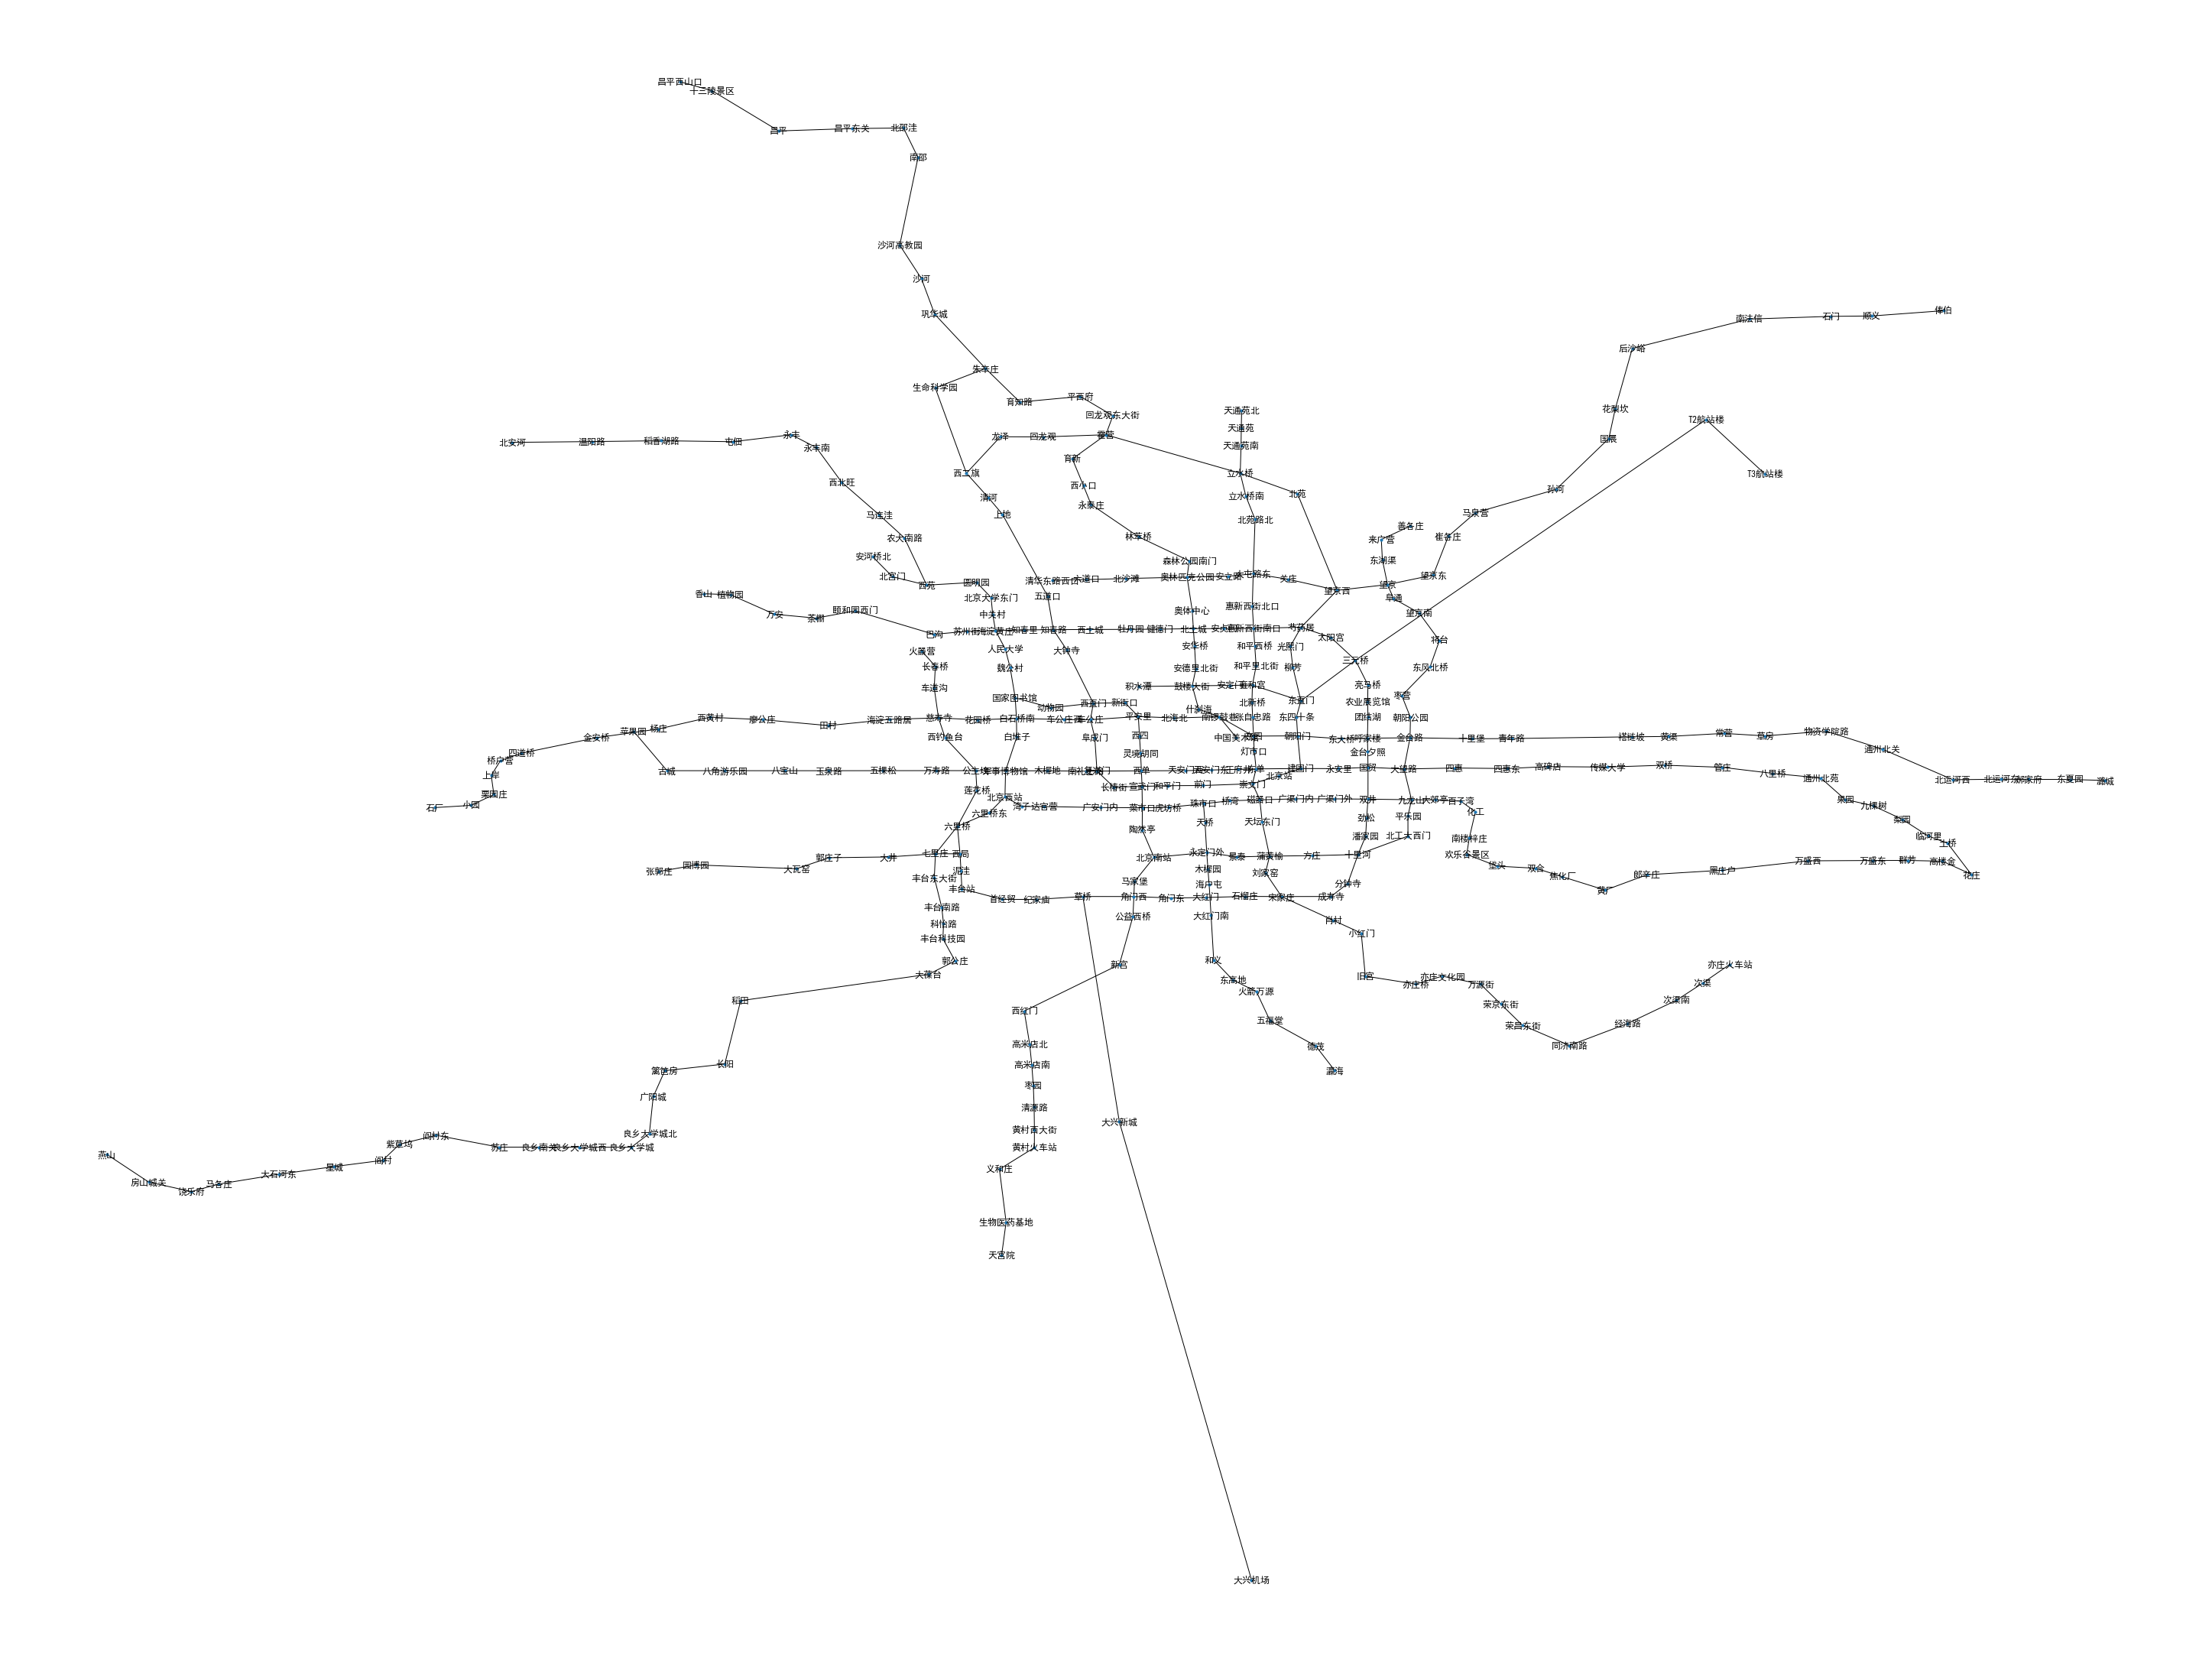

In [4]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.sans-serif'] = ['SimHei']

# 生成地铁图
plt.figure(figsize=(40,30))
station_graph = nx.Graph(neighbours)
nx.draw(station_graph,stations,with_labels=True,node_size=10)
plt.show()

In [5]:
# 第二种算法：没有启发函数的简单宽度优先
def get_path_BFS(lines_info, neighbour_info, from_station, to_station):
    # 搜索策略：以站点数量为cost（因为车票价格是按站算的）
    # 这种情况下，站点间的坐标距离难以转化为可靠的启发函数，所以只用简单的BFS算法
    # 由于每深一层就是cost加1，所以每层的cost都相同，算和不算没区别，所以省略
    
    # 检查输入站点名称
    if not neighbour_info.get(from_station):
        print('起始站点“%s”不存在。请正确输入！'%from_station)
        return None
    if not neighbour_info.get(to_station):
        print('目的站点“%s”不存在。请正确输入！'%to_station)
        return None
    
    # 搜索节点是个dict，key=站名，value是包含路过的站点list
    node = {}
    node[from_station] = [from_station]
    
    while True:
        new_node = {}
        
        for key,value in node.items():
            neighbours = neighbour_info.get(key).copy()
            
            if (len(value)>=2):
                pre_station = value[-2]
                neighbours.remove(pre_station)
                
            for i in neighbours:
                
                if i in node:
                    continue # 跳过已搜索过的节点
                path = value.copy()
                path.append(i)
                new_node[i] = path
                if i == to_station:
                    return path
        node = new_node
    
    print('未能找到路径')
    return None


paths = get_path_BFS(lines, neighbours, '回龙观', '西二旗')
print("路径总计%d站。"%(len(paths)-1))
print("-".join(paths))
# 高德导航是31站，只有1次换乘
# 代码结果是28站，但是有5次换乘
# 猜测高德的路径cost主要是时间

路径总计2站。
回龙观-龙泽-西二旗


In [5]:
# #递归查找所有路径
# def get_path_BFS(lines_info, neighbour_info, start, end):
#     # 检查输入站点是否zhengque
#     if not neighbour_info.get(start):
#         print('请输入正确的起始站点！')
#         return None
#     if not neighbour_info.get(end):
#         print('请输入正确的终点站！')
    
#     #创建node 包含： 前一站，当前站， 当前相邻站，和已走路径
#     path = []
#     cur_station = start 
#     neighbours = neighbour_info.get(start)
#     path.append(cur_station)
#     node = {'pre_station':'',
#            'cur_station':cur_station,
#            'neighbours':neighbours,
#            'path':path}
    
#     return get_next_stations_DFS_ALL(node, neighbour_info, end)

# def get_next_stations_DFS_ALL(node, neighbour_info, end):
#     neighbours = node.get('neighbours')
#     pre_station = node.get('cur_station')
#     path = node.get('path')
#     paths = []
    
#     for i in range(len(neighbours)):
#         cur_station = neighbours[i]
#         if cur_station in path:
#             return None
#         if cur_station == end:
#             path.append(cur_station)
#             paths.append(paths)
#             return paths
#         else:
#             neighbours_ = neighbour_info.get(cur_station).copy()
#             neighbours_.remove(pre_station)
#             path_ = path.copy()
#             path_.append(cur_station)
#             new_node = {'pre_station':pre_station,
#            'cur_station':cur_station,
#            'neighbours':neighbours_,
#            'path':path_}
#             paths_ = get_next_stations_DFS_ALL(new_node, neighbour_info, end)
#             if paths_:
#                 paths.extend(paths_)
#     return paths

# paths = get_path_BFS(lines, neighbours, '回龙观', '西二旗')
# print('总共有%d种路径。'%len(paths))
# for i in paths:
#     print("当前路径总共%d"%(len(i)-1))
#     print(' '.join(i))